# Cost-side panel construction
This notebook builds `cost_side_panel.csv` by parsing vehicle sourcing content,
merging plant and cost data, attaching exchange-rate measures, and exporting a
clean panel for cost-side analysis.



## Main steps
1. Load and clean manufacturer sourcing data (2016-2024).
2. Parse sourcing shares and map country codes.
3. Restrict to U.S. production and collapse duplicate product rows.
4. Build panel keys and filter for multi-year models with foreign content.
5. Merge costs/markups and vehicle characteristics.
6. Add exchange rates and trade-weighted RER index.
7. Export `cost_side_panel.csv`.



In [103]:
# Setup
import os
import re
import pandas as pd
import numpy as np
from collections import defaultdict, Counter

# Set working directory (adjust if you move the repo)
from pathlib import Path
repo_root = Path.cwd()
if not (repo_root / "processed_data").exists():
    repo_root = repo_root.parent
os.chdir(repo_root)

data_path = "processed_data/auto_sourcing/percentage_data"



In [104]:
# Load manufacturer sourcing data (2016-2024)
frames = []
for year in range(2016, 2025):
    file_path = os.path.join(data_path, f"{year}_manuf1.csv")
    if os.path.exists(file_path):
        frames.append(pd.read_csv(file_path))

data = pd.concat(frames, ignore_index=True)

# Clean key fields and rename product id
data = data.dropna(subset=["pcUSCA_content"])
data = data[~(data["pcUSCA_content"] == " ")]
data = data[~(data["pcUSCA_content"] == "G (8HP75 & 8HP75PH)")]
data = data.rename(columns={"year_make_model": "product_ids"})



In [105]:
# Parse sourcing content into percent + country codes
_PAIR_RE = re.compile(r"(\d+(?:\.\d+)?)\s*%\s*([A-Za-z/\-]+)")
_PCT_RE = re.compile(r"(\d+(?:\.\d+)?)\s*%")


def _extract_pairs(s):
    if pd.isna(s):
        return []
    s = str(s).replace("％", "%")
    out = []
    for pct, code in _PAIR_RE.findall(s):
        try:
            out.append((float(pct), code.strip().upper()))
        except ValueError:
            continue
    return out


def _get_n(lst, i, j):
    try:
        return lst[i][j]
    except Exception:
        return pd.NA


def clean_pcUSCA(s):
    if pd.isna(s):
        return pd.NA
    s = str(s).replace("％", "%")
    m = _PCT_RE.search(s)
    if not m:
        return pd.NA
    return float(m.group(1))


# US/CA content

data["pcUSCA_pct"] = data["pcUSCA_content"].apply(clean_pcUSCA).astype("Float64")

# Foreign content in pcOth1/pcOth2
for col in ["pcOth1_content", "pcOth2_content"]:
    pairs = data[col].apply(_extract_pairs)
    base = col.replace("_content", "")
    data[f"{base}_pct1"] = pairs.apply(lambda x: _get_n(x, 0, 0)).astype("Float64")
    data[f"{base}_code1"] = pairs.apply(lambda x: _get_n(x, 0, 1)).astype("string")
    data[f"{base}_pct2"] = pairs.apply(lambda x: _get_n(x, 1, 0)).astype("Float64")
    data[f"{base}_code2"] = pairs.apply(lambda x: _get_n(x, 1, 1)).astype("string")



In [106]:
# Convert percentages to decimals and drop raw content columns
for col in ["pcOth1_pct1", "pcOth2_pct1", "pcOth1_pct2", "pcOth2_pct2", "pcUSCA_pct"]:
    data[col] = data[col] / 100

data = data.drop(columns=["pcUSCA_content", "pcOth1_content", "pcOth2_content"])



In [107]:
# Map sourcing codes to country names
location_map = {
    "POLAND": "Poland",
    "GERMANY": "Germany",
    "KOREA": "Korea",
    "UNITED": "United States",
    "MEXICO": "Mexico",
    "SLOVAKIA": "Slovakia",
    "HUNGARY": "Hungary",
    "SERBIA": "Serbia",
    "VIETNAM": "Vietnam",
    "AU": "Austria",
    "AT": "Austria",
    "BE": "Belgium",
    "BR": "Brazil",
    "CH": "China",
    "CHN": "China",
    "CN": "Canada",
    "CZ": "Czech Republic",
    "DE": "Denmark",
    "ESP": "Spain",
    "F": "France",
    "FR": "France",
    "FN": "Finland",
    "G": "Germany",
    "GB": "Great Britain",
    "H": "Hungary",
    "HUN": "Hungary",
    "I": "Italy",
    "IN": "India",
    "IND": "India",
    "J": "Japan",
    "JP": "Japan",
    "K": "Korea",
    "KR": "Korea",
    "M": "Mexico",
    "MX": "Mexico",
    "N": "Netherlands",
    "OT": "Other",
    "P": "Philippines",
    "PL": "Poland",
    "PO": "Portugal",
    "SA": "South Africa",
    "SAF": "South Africa",
    "SE": "Sweden",
    "SL": "Slovakia",
    "SP": "Spain",
    "SRB": "Serbia",
    "SW": "Sweden",
    "T": "Turkey",
    "TH": "Thailand",
    "TW": "Taiwan",
    "UK": "Great Britain",
    "AF": "South Africa",
}

for code_col in ["pcOth1_code1", "pcOth1_code2", "pcOth2_code1", "pcOth2_code2"]:
    data[code_col] = data[code_col].map(location_map).fillna(data[code_col])



In [108]:
# Bring in plant-country data and keep US production
blp_data_imported = pd.read_csv("post_est/data/raw/blpUS0804.csv")
blp_data = blp_data_imported[["product_ids", "market_year", "plant_country"]]

blp_data = blp_data[
    (blp_data["plant_country"] == "United States")
    & (blp_data["product_ids"].str[:4] == blp_data["market_year"].astype(str))
]
blp_data = blp_data.drop_duplicates(subset=["product_ids", "market_year", "plant_country"])

data_merged = data.merge(blp_data, on=["product_ids"], how="left")
data_merged = data_merged.dropna(subset=["plant_country"])

# Restrict to known US assembly labels
us_locs = {
    "US", "USA", "Fremont", "CA",
    "Warren MI USA ", "Detroit Ml USA", "Toledo OH USA", "Austin, TX",
}

data_merged = data_merged[data_merged["assembly1"].isin(us_locs)]



In [109]:
# Collapse duplicate product_ids to a single row

def collapse_product_rows(df: pd.DataFrame) -> pd.DataFrame:
    oth_pct_cols = ["pcOth1_pct1", "pcOth1_pct2", "pcOth2_pct1", "pcOth2_pct2"]
    oth_code_cols = ["pcOth1_code1", "pcOth1_code2", "pcOth2_code1", "pcOth2_code2"]
    oth_pairs = list(zip(oth_code_cols, oth_pct_cols))

    na_like = {"<NA>", "NA", "NaN", "None", ""}
    out_rows = []

    def mode_or_first(series: pd.Series):
        s = series.dropna()
        if s.empty:
            return np.nan
        counts = Counter(s)
        top = counts.most_common()
        max_count = top[0][1]
        candidates = [v for v, c in top if c == max_count]
        for v in s:
            if v in candidates:
                return v
        return s.iloc[0]

    df = df.copy()
    for c in oth_code_cols + ["assembly1", "plant_country"]:
        if c in df.columns:
            df[c] = df[c].where(~df[c].astype(str).isin(na_like), np.nan)

    for c in ["pcUSCA_pct"] + oth_pct_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    for pid, g in df.groupby("product_ids", dropna=False):
        has_any_oth = g[oth_pct_cols].notna().any(axis=1)
        g_kept = g.loc[has_any_oth].copy() if has_any_oth.any() else g

        us_share = g_kept["pcUSCA_pct"].mean(skipna=True) if "pcUSCA_pct" in g_kept else np.nan

        country_sums = defaultdict(float)
        country_counts = defaultdict(int)
        for _, row in g_kept.iterrows():
            for code_col, pct_col in oth_pairs:
                country = row.get(code_col)
                pct = row.get(pct_col)
                if pd.notna(country) and pd.notna(pct):
                    country_sums[country] += float(pct)
                    country_counts[country] += 1

        foreign_avgs = [
            (ctry, country_sums[ctry] / country_counts[ctry])
            for ctry in country_sums
            if country_counts[ctry] > 0
        ]
        foreign_avgs.sort(key=lambda x: (-x[1], str(x[0])))

        fill_order = [
            ("pcOth1_code1", "pcOth1_pct1"),
            ("pcOth1_code2", "pcOth1_pct2"),
            ("pcOth2_code1", "pcOth2_pct1"),
            ("pcOth2_code2", "pcOth2_pct2"),
        ]
        filled = {c: np.nan for c in (oth_code_cols + oth_pct_cols)}
        for (code_col, pct_col), (ctry, avg) in zip(fill_order, foreign_avgs):
            filled[code_col] = ctry
            filled[pct_col] = float(avg)

        rep = {
            "product_ids": pid,
            "pcUSCA_pct": us_share,
            "pcOth1_code1": filled["pcOth1_code1"],
            "pcOth1_pct1": filled["pcOth1_pct1"],
            "pcOth1_code2": filled["pcOth1_code2"],
            "pcOth1_pct2": filled["pcOth1_pct2"],
            "pcOth2_code1": filled["pcOth2_code1"],
            "pcOth2_pct1": filled["pcOth2_pct1"],
            "pcOth2_code2": filled["pcOth2_code2"],
            "pcOth2_pct2": filled["pcOth2_pct2"],
        }

        for col in ["assembly1", "market_year", "plant_country", "vehicle_type"]:
            if col in g_kept.columns:
                rep[col] = mode_or_first(g_kept[col])

        out_rows.append(rep)

    ordered_cols = [
        "product_ids", "assembly1", "market_year", "plant_country", "vehicle_type",
        "pcUSCA_pct",
        "pcOth1_pct1", "pcOth1_code1", "pcOth1_pct2", "pcOth1_code2",
        "pcOth2_pct1", "pcOth2_code1", "pcOth2_pct2", "pcOth2_code2",
    ]
    collapsed = pd.DataFrame(out_rows)
    cols = [c for c in ordered_cols if c in collapsed.columns] + [
        c for c in collapsed.columns if c not in ordered_cols
    ]
    return collapsed[cols]


data_merged = collapse_product_rows(data_merged)



In [110]:
# Build panel keys
parts = data_merged["product_ids"].str.split("_", n=2, expand=True)
data_merged["year"] = parts[0].astype(int)
data_merged["make_model"] = parts[1] + "_" + parts[2]

data_panel = data_merged.drop(columns=[c for c in ["year_str", "make", "model"] if c in data_merged.columns])



In [111]:
# Keep only models with foreign content and multi-year coverage
filtered_panel = data_panel[data_panel["pcOth1_pct1"] > 0]
filtered_panel = filtered_panel.groupby("make_model").filter(lambda x: x["year"].nunique() >= 2)

# Drop secondary foreign slots to match existing panel structure
filtered_panel = filtered_panel.loc[:, ~filtered_panel.columns.str.startswith("pcOth2")]



In [112]:
# Merge costs, markups, and engine-type flags
costs_df = pd.read_csv("post_est/data/derived/vehicle_costs_markups_chars.csv")
costs_df = costs_df[[
    "product_ids", "market_year", "costs", "markups", "engine_type", "ev", "hybrid"
]]

costs_df = costs_df[(costs_df["market_year"] >= 2016) & (costs_df["market_year"] <= 2024)]
costs_df = costs_df[costs_df["product_ids"].str[:4] == costs_df["market_year"].astype(str)]

costs_keyed = (
    costs_df
    .dropna(subset=["product_ids", "market_year"])
    .drop_duplicates(subset=["product_ids", "market_year"], keep="last")
)

filtered_panel = filtered_panel.merge(
    costs_keyed,
    on=["product_ids", "market_year"],
    how="inner",
    validate="many_to_one",
)



In [113]:
# Add vehicle characteristics from BLP
blp_chars = blp_data_imported[
    blp_data_imported["product_ids"].str[:4] == blp_data_imported["market_year"].astype(str)
]
blp_chars = blp_chars[["product_ids", "size", "weight", "hp", "mpg"]]
blp_chars = blp_chars.drop_duplicates(subset=["product_ids", "size", "weight", "hp", "mpg"])

filtered_panel = filtered_panel.merge(blp_chars, on="product_ids", how="left")



In [114]:
# Import indices and exchange rates
import_index_data = pd.read_csv("processed_data/auto_sourcing/parts_imports_countries.csv")
import_index_data = import_index_data.rename(columns={"Partner": "country"}).head(30)
import_index_data = import_index_data.drop(columns=["2008", "2009", "2010", "2011", "2012", "2013"])

exchange_data = pd.read_csv("processed_data/exchange_rates/exchange_rates.csv")
exchange_data = exchange_data.drop(columns=["Country Code", "2010", "2011", "2012", "2013"])
exchange_data = exchange_data.rename(columns={"Country Name": "country"})
exchange_data = exchange_data[exchange_data["country"].isin(import_index_data["country"])]



In [115]:
# Clean import index
cleaned_imports = import_index_data.copy()
if cleaned_imports.columns[0] != "country":
    cleaned_imports = cleaned_imports.rename(columns={cleaned_imports.columns[0]: "country"})

num_cols = [c for c in cleaned_imports.columns if c != "country"]
cleaned_imports[num_cols] = (
    cleaned_imports[num_cols]
    .replace({r"[,\s]": ""}, regex=True)
    .replace({"": np.nan})
    .apply(pd.to_numeric, errors="coerce")
    .astype("Int64")
)



In [116]:
# Normalize exchange rates and attach to panel

def normalize_exchange_to_2015(ex: pd.DataFrame) -> pd.DataFrame:
    ex = ex.copy()
    if ex.columns[0] != "country":
        ex = ex.rename(columns={ex.columns[0]: "country"})

    year_cols = [c for c in ex.columns if c != "country"]
    if "2015" in ex.columns:
        col2015 = "2015"
    elif 2015 in ex.columns:
        col2015 = 2015
    else:
        raise ValueError("exchange_data must contain a 2015 column to normalize.")

    ex[year_cols] = ex[year_cols].apply(pd.to_numeric, errors="coerce")
    denom = ex[col2015].replace({0: np.nan})
    ex_norm = ex.copy()
    ex_norm[year_cols] = ex_norm[year_cols].div(denom, axis=0).astype(float)
    return ex_norm


def _exchange_long(ex_df: pd.DataFrame) -> pd.DataFrame:
    ex = ex_df.copy()
    if ex.columns[0] != "country":
        ex = ex.rename(columns={ex.columns[0]: "country"})
    long = ex.melt(id_vars="country", var_name="year", value_name="rer")
    long["year"] = pd.to_numeric(long["year"], errors="coerce").astype("Int64")
    long["rer"] = pd.to_numeric(long["rer"], errors="coerce").astype(float)
    return long


def add_rer_column(df: pd.DataFrame, exchange_df: pd.DataFrame,
                   code_col: str, out_col: str, year_col: str = "year") -> pd.DataFrame:
    out = df.copy()
    out["_year_join"] = pd.to_numeric(out[year_col], errors="coerce").astype("Int64")
    ex_long = _exchange_long(exchange_df)

    merged = out.merge(
        ex_long,
        left_on=[code_col, "_year_join"],
        right_on=["country", "year"],
        how="left",
    )
    out[out_col] = merged["rer"].values
    return out.drop(columns=["_year_join"])


exchange_data_norm = normalize_exchange_to_2015(exchange_data)

final_df = add_rer_column(
    filtered_panel,
    exchange_data_norm,
    code_col="pcOth1_code1",
    out_col="rer_pcOth1_code1_n2015",
    year_col="year",
)

final_df = add_rer_column(
    final_df,
    exchange_data_norm,
    code_col="pcOth1_code2",
    out_col="rer_pcOth1_code2_n2015",
    year_col="year",
)


# Keep a pre-drop snapshot for NA diagnostics
final_df_pre_drop = final_df.copy()

final_df = final_df.dropna(subset=["rer_pcOth1_code1_n2015"])

# --- Diagnostics: shifts in sourcing and NA coverage ---
# 1) Products (make_model) that change pcOth1_code1 over time
code_changes = (
    final_df_pre_drop
    .groupby("make_model")["pcOth1_code1"]
    .nunique(dropna=True)
)
num_change = (code_changes > 1).sum()
print(f"make_model with pcOth1_code1 changes: {num_change} / {code_changes.shape[0]}")

# 2) NA share for pcOth1_code1 among US-built vehicles (pre/post drop)
pre_us = final_df_pre_drop[final_df_pre_drop["plant_country"] == "United States"]
pre_na = pre_us["pcOth1_code1"].isna().sum()
pre_n = pre_us.shape[0]
pre_pct = 100 * pre_na / pre_n if pre_n else 0
print(f"US-built pcOth1_code1 NA (pre-drop): {pre_na} / {pre_n} ({pre_pct:.1f}%)")

post_us = final_df[final_df["plant_country"] == "United States"]
post_na = post_us["pcOth1_code1"].isna().sum()
post_n = post_us.shape[0]
post_pct = 100 * post_na / post_n if post_n else 0
print(f"US-built pcOth1_code1 NA (post-drop): {post_na} / {post_n} ({post_pct:.1f}%)")



make_model with pcOth1_code1 changes: 14 / 108
US-built pcOth1_code1 NA (pre-drop): 0 / 487 (0.0%)
US-built pcOth1_code1 NA (post-drop): 0 / 485 (0.0%)


In [117]:
# Build trade-weighted RER index from imports

def build_trade_weighted_rer(cleaned_imports: pd.DataFrame,
                             exchange_data_norm: pd.DataFrame) -> pd.DataFrame:
    imp = cleaned_imports.copy()
    if imp.columns[0] != "country":
        imp = imp.rename(columns={imp.columns[0]: "country"})
    ex = exchange_data_norm.copy()
    if ex.columns[0] != "country":
        ex = ex.rename(columns={ex.columns[0]: "country"})

    imp_long = imp.melt(id_vars="country", var_name="year", value_name="imports")
    ex_long = ex.melt(id_vars="country", var_name="year", value_name="rer")

    imp_long["year"] = pd.to_numeric(imp_long["year"], errors="coerce").astype("Int64")
    ex_long["year"] = pd.to_numeric(ex_long["year"], errors="coerce").astype("Int64")
    imp_long["imports"] = pd.to_numeric(imp_long["imports"], errors="coerce")
    ex_long["rer"] = pd.to_numeric(ex_long["rer"], errors="coerce")

    df = imp_long.merge(ex_long, on=["country", "year"], how="inner")
    df["w"] = df["imports"] * df["rer"]

    agg = df.groupby("year", as_index=False).agg(
        weighted_sum=("w", "sum"),
        import_sum_matched=("imports", "sum"),
        countries_used=("country", "nunique"),
    )

    total_imp = imp_long.groupby("year", as_index=False).agg(total_imports=("imports", "sum"))
    out = agg.merge(total_imp, on="year", how="left")
    out["tw_rer_index"] = out["weighted_sum"] / out["import_sum_matched"]
    out["coverage_share"] = out["import_sum_matched"] / out["total_imports"]

    return out[[
        "year", "tw_rer_index", "coverage_share", "countries_used",
        "import_sum_matched", "total_imports"
    ]].sort_values("year").reset_index(drop=True)


tw_rer_by_year = build_trade_weighted_rer(cleaned_imports, exchange_data_norm)
final_df = final_df.merge(tw_rer_by_year[["year", "tw_rer_index"]], on="year", how="left")



In [118]:
# Final touches and export
final_df["costs"] = final_df["costs"] * 10
final_df["make"] = final_df["make_model"].str.split("_").str[0]

final_df.to_csv("cost_side/cost_side_panel.csv", index=False)


# Export a version with switchers removed
switchers = [
    "bmw_x5",
    "bmw_x7",
    "cadillac_ct6",
    "chevrolet_colorado",
    "chevrolet_sonic",
    "gmc_canyon",
    "nissan_maxima",
    "tesla_model3ev",
    "toyota_tundra",
    "volkswagen_atlas",
    "volkswagen_atlascrosssport",
    "volkswagen_passat",
]
final_df_no_switchers = final_df[~final_df["make_model"].isin(switchers)].copy()
final_df_no_switchers.to_csv("cost_side/cost_side_panel_dropped.csv", index=False)



## Analysis: pcOth1_pct1 distribution
Summary statistics and binned distribution for the foreign content share used in the panel.



pcOth1_pct1 summary
count    485.000000
mean       0.275434
std        0.108615
min        0.100000
1%         0.142000
5%         0.150000
10%        0.150000
25%        0.200000
50%        0.250000
75%        0.350000
90%        0.440000
95%        0.480000
99%        0.551600
max        0.750000
Name: pcOth1_pct1, dtype: float64

pcOth1_pct1 binned counts
pcOth1_pct1
(-0.001, 0.01]      0
(0.01, 0.05]        0
(0.05, 0.1]         5
(0.1, 0.2]        160
(0.2, 0.3]        168
(0.3, 0.4]         93
(0.4, 0.5]         47
(0.5, 0.75]        12
(0.75, 1.0]         0
Name: count, dtype: int64


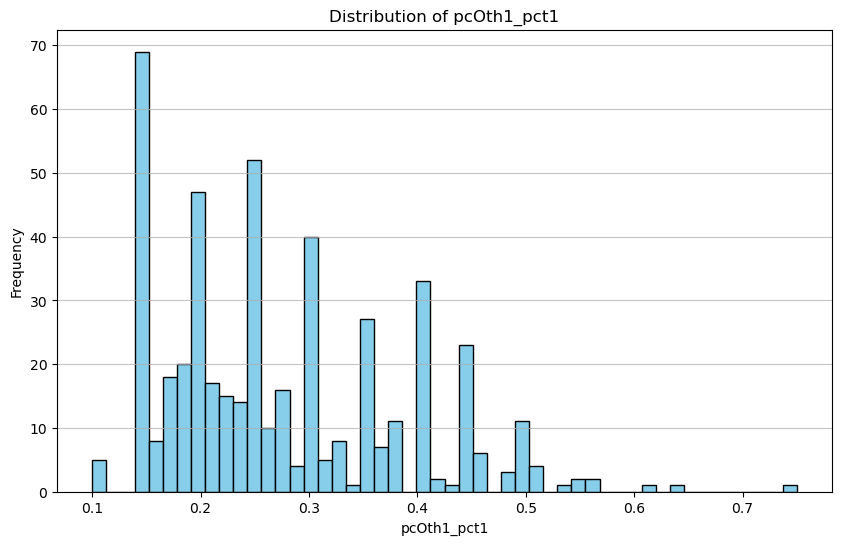

In [120]:
# Distribution of pcOth1_pct1
s = final_df["pcOth1_pct1"].dropna()

print("pcOth1_pct1 summary")
print(s.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

# Binned distribution (0-1 by default; adjust bins if needed)
bins = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0]
binned = pd.cut(s, bins=bins, include_lowest=True)
print("\npcOth1_pct1 binned counts")
print(binned.value_counts().sort_index())

# Plot the distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(s, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of pcOth1_pct1')
plt.xlabel('pcOth1_pct1')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()
